In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.stats import norm

In [3]:
input_data = np.load("/content/drive/MyDrive/MTP/Dataset-2/inputs_Dataset-2.npy")
output_data = np.load("/content/drive/MyDrive/MTP/Dataset-2/outputs_Dataset-2.npy")
input_data = input_data[:,1:]


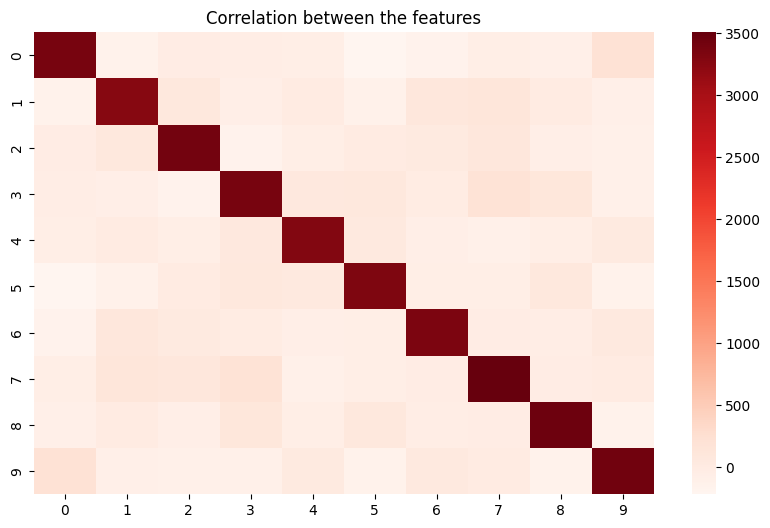

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(np.cov(input_data.T), cmap='Reds', annot=False)  # cmap is the color map for the heatmap
plt.title('Correlation between the features')
plt.show()

In [ ]:
import csv
import os
def write_to_csv(data,csv_file_path):
    # Check if the CSV file exists
    if os.path.exists(csv_file_path):
        # Read the existing data from the CSV file
        existing_data = pd.read_csv(csv_file_path, header=None).values.tolist()
    else:
        existing_data = []

    # Transpose the data to write it in columns
    data = [data]  # Convert data into a list of lists
    data = list(map(list, zip(*data)))  # Transpose the data

    # Append the new data to the existing data
    if existing_data:
        for i in range(min(len(existing_data), len(data))):
            existing_data[i].extend(data[i])
    else:
        existing_data = data

    # Write the combined data to the CSV file
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Write the data to the CSV file column-wise
        for row in existing_data:
            writer.writerow(row)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.2, random_state=42)

In [ ]:
def sampling(n,input,output):
    indices = np.random.choice(len(input),n,replace=False)
    bootstrap_X = X_train[indices]
    bootstrap_y = y_train[indices]
    return bootstrap_X,bootstrap_y

def create_model():
    model = keras.Sequential()
    model.add(layers.Input(shape=(10,)))
    model.add(layers.Dense(4, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_table(model,input,output):
    pred = model.predict(input)
    pred[pred>=0.5] = 1
    pred[pred<0.5] = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0

    # Calculate confusion matrix values
    for i in range(len(pred)):
        if output[i] == 1 and pred[i] == 1:
            true_positives += 1
        elif output[i] == 0 and pred[i] == 0:
            true_negatives += 1
        elif output[i] == 0 and pred[i] == 1:
            false_positives += 1
        elif output[i] == 1 and pred[i] == 0:
            false_negatives += 1

    # Create the confusion matrix as a list of lists
    confusion_matrix_result = [[true_negatives, false_positives],
                            [false_negatives, true_positives]]

    # Convert the confusion matrix to a numpy array for better visualization (optional)
    confusion_matrix_array = np.array(confusion_matrix_result)
    return confusion_matrix_array

def joint_odds_ratio(tables):
    k = len(tables)
    num = 0
    den = 0
    for i in range(k):
        sum = tables[i][0][0] + tables[i][0][1] + tables[i][1][1] + tables[i][1][0]
        num = num + (tables[i][0][0]*tables[i][1][1])/sum
        den = den + (tables[i][0][1]*tables[i][1][0])/sum
    return num/den

def odds_ratio(table):
    pA = table[0][0]/(table[0][0]+table[1][0])
    pB = table[0][1]/(table[0][1]+table[1][1])
    return (pA*(1-pB))/(pB*(1-pA))

In [ ]:
import time
n_ensembles = 100
ensemble_odds_ratio_train = []
ensemble_odds_ratio_test = []
for v in range(n_ensembles):
    # Start timing the training process
    start_time = time.time()
    k = 10
    n = 500
    models = []
    for i in range(k):
        model = create_model()
        models.append(model)
    train_tables = []
    test_tables = []
    for i in range(k):
        sampled_X,sampled_y = sampling(n,X_train,y_train)
        # with tf.device('/GPU:0'):
        models[i].fit(sampled_X, sampled_y, epochs=10, verbose = 0)

        train_tables.append(create_table(models[i],sampled_X,sampled_y))
        test_tables.append(create_table(models[i],X_test,y_test))
    ensemble_odds_ratio_train.append(joint_odds_ratio(train_tables))
    ensemble_odds_ratio_test.append(joint_odds_ratio(test_tables))

    # End timing
    end_time = time.time()
    print(v, " : ", end_time-start_time)

7/7 [==============================] - 0s 2ms/step
0  :  16.752453804016113
7/7 [==============================] - 0s 2ms/step
1  :  13.826649904251099
7/7 [==============================] - 0s 2ms/step
2  :  15.235629081726074
7/7 [==============================] - 0s 2ms/step
3  :  14.211069822311401
7/7 [==============================] - 0s 2ms/step
4  :  13.870519399642944
7/7 [==============================] - 0s 2ms/step
5  :  16.36969518661499
7/7 [==============================] - 0s 2ms/step
6  :  14.11268162727356
7/7 [==============================] - 0s 2ms/step
7  :  15.89277696609497
7/7 [==============================] - 0s 2ms/step
8  :  14.06142783164978
7/7 [==============================] - 0s 2ms/step
9  :  15.902509212493896
7/7 [==============================] - 0s 3ms/step
10  :  14.303733825683594
7/7 [==============================] - 0s 3ms/step
11  :  13.527045965194702
7/7 [==============================] - 0s 3ms/step
12  :  16.832552909851074
7/7 [========

In [4]:
train_csv_file_path = "/content/drive/MyDrive/MTP/Train_Odds_Ratio.csv"
test_csv_file_path = "/content/drive/MyDrive/MTP/Test_Odds_Ratio.csv"

In [5]:
# write_to_csv(ensemble_odds_ratio_train,train_csv_file_path)
# write_to_csv(ensemble_odds_ratio_test,test_csv_file_path)

NameError: ignored

In [7]:
train_df = pd.read_csv(train_csv_file_path)
test_df = pd.read_csv(test_csv_file_path)
ensemble_odds_ratio_train = train_df.values.ravel().tolist()
ensemble_odds_ratio_test = test_df.values.ravel().tolist()
ensemble_odds_ratio_train += [float(value) for value in train_df.columns.values.tolist()]
ensemble_odds_ratio_test += [float(value) for value in test_df.columns.values.tolist()]

In [8]:
print(len(ensemble_odds_ratio_train))
print(len(ensemble_odds_ratio_test))

1000
1000


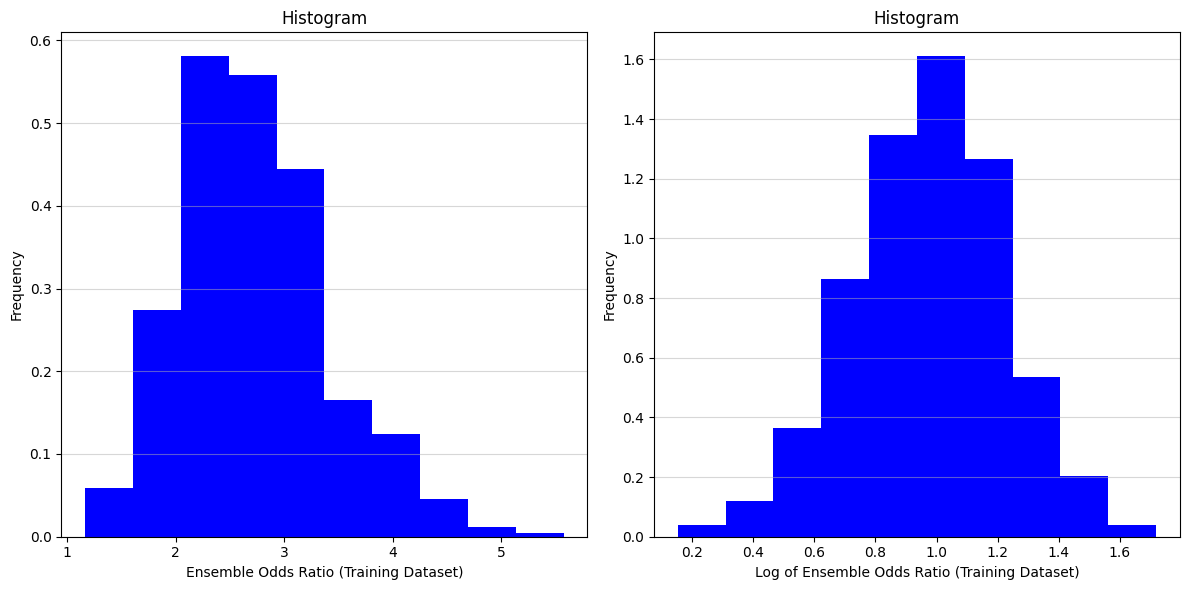

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot a histogram
axes[0].hist(ensemble_odds_ratio_train, density=True, color='b')
axes[0].set_xlabel('Ensemble Odds Ratio (Training Dataset)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram')
axes[0].grid(axis='y', alpha=0.5)

axes[1].hist(np.log(ensemble_odds_ratio_train), density=True, color='b')
axes[1].set_xlabel('Log of Ensemble Odds Ratio (Training Dataset)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram')
axes[1].grid(axis='y', alpha=0.5)

# Plot a KDE plot
# sns.kdeplot(np.log(ensemble_odds_ratio_train), fill=True, ax=axes[1])
# axes[1].set_xlabel('Ensemble Odds Ratio')
# axes[1].set_ylabel('Density')
# axes[1].set_title('KDE Plot')
# axes[1].grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

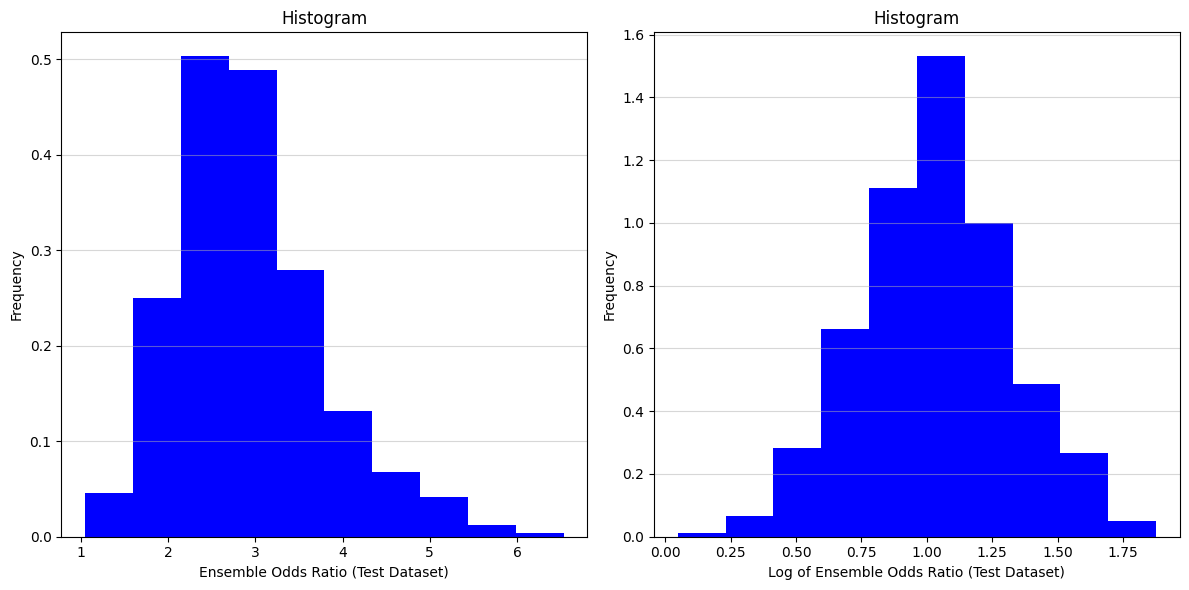

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot a histogram
axes[0].hist(ensemble_odds_ratio_test, density=True, color='b')
axes[0].set_xlabel('Ensemble Odds Ratio (Test Dataset)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram')
axes[0].grid(axis='y', alpha=0.5)

axes[1].hist(np.log(ensemble_odds_ratio_test), density=True, color='b')
axes[1].set_xlabel('Log of Ensemble Odds Ratio (Test Dataset)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram')
axes[1].grid(axis='y', alpha=0.5)

# Plot a KDE plot
# sns.kdeplot(np.log(ensemble_odds_ratio_train), fill=True, ax=axes[1])
# axes[1].set_xlabel('Ensemble Odds Ratio')
# axes[1].set_ylabel('Density')
# axes[1].set_title('KDE Plot')
# axes[1].grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

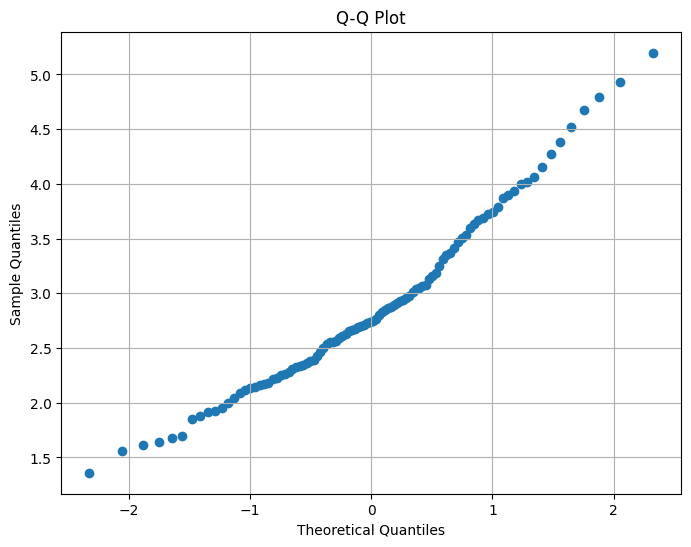

In [ ]:
import scipy.stats as stats
# Calculate the theoretical quantiles for a normal distribution
theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, 100))

# Sort your dataset
sorted_data = np.sort(ensemble_odds_ratio_test)

# Calculate the sample quantiles
sample_quantiles = np.percentile(sorted_data, np.linspace(1, 99, 100))

# Create a Q-Q plot
plt.figure(figsize=(8, 6))
plt.scatter(theoretical_quantiles, sample_quantiles)
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.title("Q-Q Plot")
plt.grid(True)
plt.show()

In [ ]:
# Perform the D'Agostino-Pearson normality test
data = np.log(ensemble_odds_ratio_test)
statistic, p_value = stats.normaltest(data)

# Set the significance level
alpha = 0.05

# Print the test statistic and p-value
print('D\'Agostino-Pearson Test Statistic:', statistic)
print('p-value:', p_value)

# Determine whether the data is normal based on the p-value
if p_value < alpha:
    print('The data does not appear to be normally distributed (reject null hypothesis)')
else:
    print('The data appears to be normally distributed (fail to reject null hypothesis)')

D'Agostino-Pearson Test Statistic: 0.6954887953920728
p-value: 0.7062793797815521
The data appears to be normally distributed (fail to reject null hypothesis)


In [ ]:
# Perform the D'Agostino-Pearson normality test
data = ensemble_odds_ratio_test
statistic, p_value = stats.normaltest(data)

# Set the significance level
alpha = 0.05

# Print the test statistic and p-value
print('D\'Agostino-Pearson Test Statistic:', statistic)
print('p-value:', p_value)

# Determine whether the data is normal based on the p-value
if p_value < alpha:
    print('The data does not appear to be normally distributed (reject null hypothesis)')
else:
    print('The data appears to be normally distributed (fail to reject null hypothesis)')

D'Agostino-Pearson Test Statistic: 21.448674035648242
p-value: 2.2002884098229874e-05
The data does not appear to be normally distributed (reject null hypothesis)


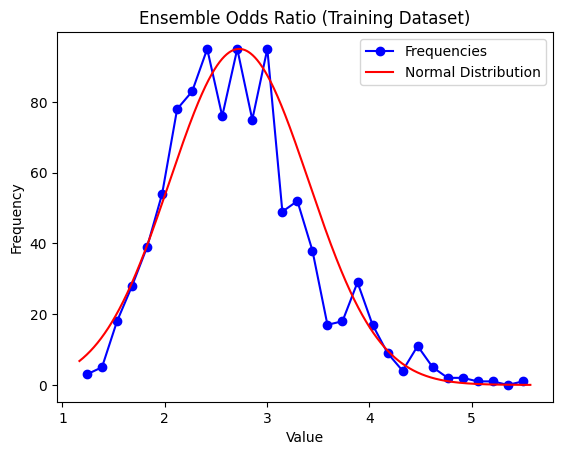

Mean: 2.7275821881157833
Variance: 0.4614458584761295


In [ ]:
data = ensemble_odds_ratio_train
hist, bins = np.histogram(data,bins=30)
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, hist, marker='o', linestyle='-', color='b', label='Frequencies')
mean = np.mean(data)
variance = np.var(data)
x = np.linspace(min(data), max(data), 1000)
normal_curve = norm.pdf(x, mean, np.sqrt(variance))
area_under_hist = np.max(hist)
area_under_normal = np.max(normal_curve)
normal_curve *= (area_under_hist/area_under_normal)

plt.plot(x, normal_curve, 'r-', label='Normal Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Ensemble Odds Ratio (Training Dataset)')
plt.legend()
plt.show()
print("Mean:", mean)
print("Variance:", variance)

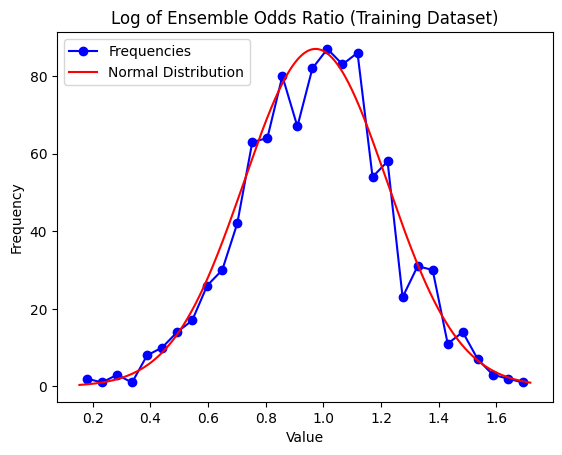

Mean: 0.9728371463546442
Variance: 0.06163082577860093


In [ ]:
data = np.log(ensemble_odds_ratio_train)
hist, bins = np.histogram(data,bins=30)
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, hist, marker='o', linestyle='-', color='b', label='Frequencies')
mean = np.mean(data)
variance = np.var(data)
x = np.linspace(min(data), max(data), 1000)
normal_curve = norm.pdf(x, mean, np.sqrt(variance))
area_under_hist = np.max(hist)
area_under_normal = np.max(normal_curve)
normal_curve *= (area_under_hist/area_under_normal)

plt.plot(x, normal_curve, 'r-', label='Normal Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Log of Ensemble Odds Ratio (Training Dataset)')
plt.legend()
plt.show()
print("Mean:", mean)
print("Variance:", variance)

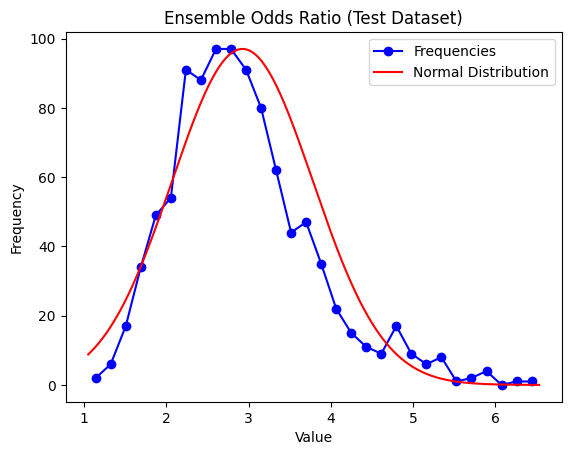

Mean: 2.925127253885045
Variance: 0.7335516387306585


In [ ]:
data = ensemble_odds_ratio_test
hist, bins = np.histogram(data,bins=30)
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, hist, marker='o', linestyle='-', color='b', label='Frequencies')
mean = np.mean(data)
variance = np.var(data)
x = np.linspace(min(data), max(data), 1000)
normal_curve = norm.pdf(x, mean, np.sqrt(variance))
area_under_hist = np.max(hist)
area_under_normal = np.max(normal_curve)
normal_curve *= (area_under_hist/area_under_normal)

plt.plot(x, normal_curve, 'r-', label='Normal Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Ensemble Odds Ratio (Test Dataset)')
plt.legend()
plt.show()
print("Mean:", mean)
print("Variance:", variance)

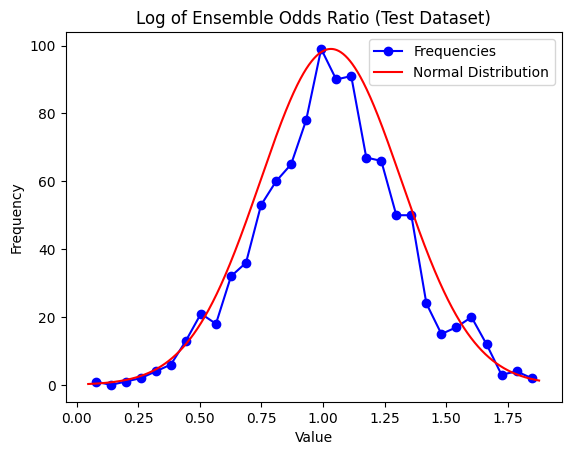

Mean: 1.0322276014652025
Variance: 0.08215499891903624


In [ ]:
# Calculate the frequency of each value
data = np.log(ensemble_odds_ratio_test)

# Calculate the histogram with 30 bins
hist, bins = np.histogram(data,bins=30)

# Calculate the bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot the frequencies
plt.plot(bin_centers, hist, marker='o', linestyle='-', color='b', label='Frequencies')

# Calculate mean and variance
mean = np.mean(data)
variance = np.var(data)

# Generate the normal distribution curve
x = np.linspace(min(data), max(data), 1000)
normal_curve = norm.pdf(x, mean, np.sqrt(variance))

# Normalize the normal curve to match the frequency scale
area_under_hist = np.max(hist)
area_under_normal = np.max(normal_curve)
normal_curve *= (area_under_hist/area_under_normal)

# Plot the normal distribution
plt.plot(x, normal_curve, 'r-', label='Normal Distribution')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Log of Ensemble Odds Ratio (Test Dataset)')
plt.legend()
plt.show()

print("Mean:", mean)
print("Variance:", variance)

In [9]:
import numpy as np
from scipy.stats import ks_2samp
ks_statistic, p_value = ks_2samp(np.log(ensemble_odds_ratio_train), np.log(ensemble_odds_ratio_test))


In [10]:
ks_statistic

0.115

In [11]:
p_value

3.528972349889754e-06

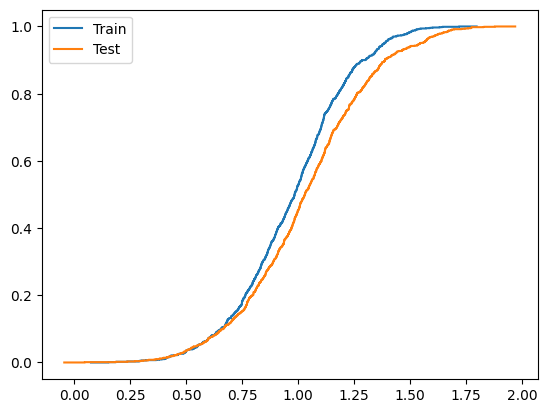

In [16]:
import matplotlib.pyplot as plt
from scipy import stats
res_train = stats.ecdf(np.log(ensemble_odds_ratio_train))
ax = plt.subplot()
res_train.cdf.plot(ax)
res_test = stats.ecdf(np.log(ensemble_odds_ratio_test))
res_test.cdf.plot(ax)
ax.legend(['Train','Test'])
plt.show()